In [18]:
import sys
try:
    from ompl import util as ou
    from ompl import base as ob
    from ompl import geometric as og
except ImportError:
    # if the ompl module is not in the PYTHONPATH assume it is installed in a
    # subdirectory of the parent directory called "py-bindings."
    from os.path import abspath, dirname, join
    sys.path.insert(0, join(dirname(dirname(abspath(__file__))), 'py-bindings'))
    from ompl import util as ou
    from ompl import base as ob
    from ompl import geometric as og
from math import sqrt
import argparse

## @cond IGNORE
# Our "collision checker". For this demo, our robot's state space
# lies in [0,1]x[0,1], with a circular obstacle of radius 0.25
# centered at (0.5,0.5). Any states lying in this circular region are
# considered "in collision".
class ValidityChecker(ob.StateValidityChecker):
    def __init__(self, si, min_distance):
        super(ValidityChecker, self).__init__(si)
        self.min_distance = min_distance
    # Returns whether the given state's position overlaps the
    # circular obstacle
    def isValid(self, state):
        return self.clearance(state) > self.min_distance

    # Returns the distance from the given state's position to the
    # boundary of the circular obstacle.
    def clearance(self, state):
        # Extract the robot's (x,y) position from its state
        x = state[0]
        y = state[1]
        z = state[2]

        # Distance formula between three points, offset by the circle's
        # radius
        return sqrt((x - 0.5)**2 + (y - 0.5)**2 + (z - 0.5)**2) - 0.25


## Returns a structure representing the optimization objective to use
#  for optimal motion planning. This method returns an objective
#  which attempts to minimize the length in configuration space of
#  computed paths.
def getPathLengthObjective(si):
    return ob.PathLengthOptimizationObjective(si)

## Returns an optimization objective which attempts to minimize path
#  length that is satisfied when a path of length shorter than 1.51
#  is found.
def getThresholdPathLengthObj(si):
    obj = ob.PathLengthOptimizationObjective(si)
    obj.setCostThreshold(ob.Cost(1.51))
    return obj

## Defines an optimization objective which attempts to steer the
#  robot away from obstacles. To formulate this objective as a
#  minimization of path cost, we can define the cost of a path as a
#  summation of the costs of each of the states along the path, where
#  each state cost is a function of that state's clearance from
#  obstacles.
#
#  The class StateCostIntegralObjective represents objectives as
#  summations of state costs, just like we require. All we need to do
#  then is inherit from that base class and define our specific state
#  cost function by overriding the stateCost() method.
#
class ClearanceObjective(ob.StateCostIntegralObjective):
    def __init__(self, si):
        super(ClearanceObjective, self).__init__(si, True)
        self.si_ = si

    # Our requirement is to maximize path clearance from obstacles,
    # but we want to represent the objective as a path cost
    # minimization. Therefore, we set each state's cost to be the
    # reciprocal of its clearance, so that as state clearance
    # increases, the state cost decreases.
    def stateCost(self, s):
        return ob.Cost(1 / (self.si_.getStateValidityChecker().clearance(s) +
                            sys.float_info.min))

## Return an optimization objective which attempts to steer the robot
#  away from obstacles.
def getClearanceObjective(si):
    return ClearanceObjective(si)

## Create an optimization objective which attempts to optimize both
#  path length and clearance. We do this by defining our individual
#  objectives, then adding them to a MultiOptimizationObjective
#  object. This results in an optimization objective where path cost
#  is equivalent to adding up each of the individual objectives' path
#  costs.
#
#  When adding objectives, we can also optionally specify each
#  objective's weighting factor to signify how important it is in
#  optimal planning. If no weight is specified, the weight defaults to
#  1.0.
def getBalancedObjective1(si):
    lengthObj = ob.PathLengthOptimizationObjective(si)
    clearObj = ClearanceObjective(si)

    opt = ob.MultiOptimizationObjective(si)
    opt.addObjective(lengthObj, 5.0)
    opt.addObjective(clearObj, 1.0)

    return opt

## Create an optimization objective equivalent to the one returned by
#  getBalancedObjective1(), but use an alternate syntax.
#  THIS DOESN'T WORK YET. THE OPERATORS SOMEHOW AREN'T EXPORTED BY Py++.
# def getBalancedObjective2(si):
#     lengthObj = ob.PathLengthOptimizationObjective(si)
#     clearObj = ClearanceObjective(si)
#
#     return 5.0*lengthObj + clearObj


## Create an optimization objective for minimizing path length, and
#  specify a cost-to-go heuristic suitable for this optimal planning
#  problem.
def getPathLengthObjWithCostToGo(si):
    obj = ob.PathLengthOptimizationObjective(si)
    obj.setCostToGoHeuristic(ob.CostToGoHeuristic(ob.goalRegionCostToGo))
    return obj


# Keep these in alphabetical order and all lower case
def allocatePlanner(si, plannerType):
    if plannerType.lower() == "bfmtstar":
        return og.BFMT(si)
    elif plannerType.lower() == "bitstar":
        return og.BITstar(si)
    elif plannerType.lower() == "fmtstar":
        return og.FMT(si)
    elif plannerType.lower() == "informedrrtstar":
        return og.InformedRRTstar(si)
    elif plannerType.lower() == "prmstar":
        return og.PRMstar(si)
    elif plannerType.lower() == "rrtstar":
        return og.RRTstar(si)
    elif plannerType.lower() == "sorrtstar":
        return og.SORRTstar(si)
    else:
        ou.OMPL_ERROR("Planner-type is not implemented in allocation function.")


# Keep these in alphabetical order and all lower case
def allocateObjective(si, objectiveType):
    if objectiveType.lower() == "pathclearance":
        return getClearanceObjective(si)
    elif objectiveType.lower() == "pathlength":
        return getPathLengthObjective(si)
    elif objectiveType.lower() == "thresholdpathlength":
        return getThresholdPathLengthObj(si)
    elif objectiveType.lower() == "weightedlengthandclearancecombo":
        return getBalancedObjective1(si)
    else:
        ou.OMPL_ERROR("Optimization-objective is not implemented in allocation function.")



def plan(runTime, plannerType, objectiveType, fname, interpolationnumber, min_distance):
    # Construct the robot state space in which we're planning. We're
    # planning in [0,1]x[0,1]x[0,1], a subset of R^3.
    space = ob.RealVectorStateSpace(3)

    # Set the bounds of space to be in [0,1].
    space.setBounds(0.0, 1.0)

    # Construct a space information instance for this state space
    si = ob.SpaceInformation(space)

    # Set the object used to check which states in the space are valid
    validityChecker = ValidityChecker(si, min_distance)
    si.setStateValidityChecker(validityChecker)

    si.setup()

    # Set our robot's starting state to be the bottom-left corner of
    # the environment, or (0,0).
    start = ob.State(space)
    start[0] = 0.0546
    start[1] = 0.90014
    start[2] = 0.95113

    # Set our robot's goal state to be the top-right corner of the
    # environment, or (1,1).
    goal = ob.State(space)
    goal[0] = 0.65
    goal[1] = 0.3
    goal[2] = 0.4

    # Create a problem instance
    pdef = ob.ProblemDefinition(si)

    # Set the start and goal states
    pdef.setStartAndGoalStates(start, goal)

    # Create the optimization objective specified by our command-line argument.
    # This helper function is simply a switch statement.
    pdef.setOptimizationObjective(allocateObjective(si, objectiveType))

    # Construct the optimal planner specified by our command line argument.
    # This helper function is simply a switch statement.
    optimizingPlanner = allocatePlanner(si, plannerType)

    # Set the problem instance for our planner to solve
    optimizingPlanner.setProblemDefinition(pdef)
    optimizingPlanner.setup()

    # attempt to solve the planning problem in the given runtime
    solved = optimizingPlanner.solve(runTime)

    if solved:
        path = pdef.getSolutionPath()
        path.interpolate(interpolationnumber)
        
        # Output the length of the path found
        print('{0} found solution of path length {1:.4f} with an optimization ' \
            'objective value of {2:.4f}'.format( \
            optimizingPlanner.getName(), \
            pdef.getSolutionPath().length(), \
            pdef.getSolutionPath().cost(pdef.getOptimizationObjective()).value()))

        # If a filename was specified, output the path as a matrix to
        # that file for visualization
        if fname:
            with open(fname, 'w') as outFile:
                outFile.write(pdef.getSolutionPath().printAsMatrix())
        
        path_states = pdef.getSolutionPath().getStates()
        points = [[s[0], s[1], s[2]] for s in path_states]
        return points
    else:
        print("No solution found.")

if __name__ == "__main__":
    runtime = 2.0
    plannerType = "RRTstar"
    objectiveType = "PathLength"
    filename = "output.txt" # oder z.B. "path_output.txt"
    interpolationnumber = 5
    min_distance = 0.2
    
    points = plan(runtime, plannerType, objectiveType, filename, interpolationnumber, min_distance)
    
## @endcond

Debug:   RRTstar: Planner range detected to be 0.346410
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 0.00000.
Info:    RRTstar: Initial k-nearest value of 45
RRTstar found solution of path length 1.4596 with an optimization objective value of 1.4596
Info:    ProblemDefinition: Adding approximate solution from planner RRTstar
Info:    RRTstar: Created 2622 new states. Checked 1103267 rewire options. 0 goal states in tree. Final solution cost inf


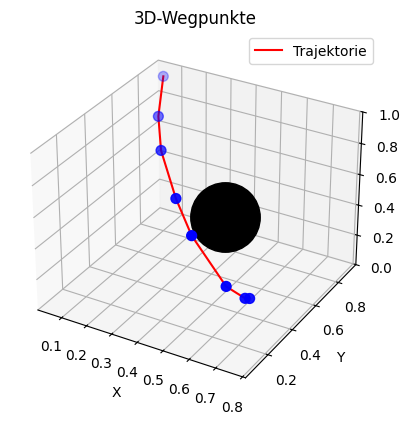

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Listen entpacken
xs, ys, zs = zip(*points)

# Plot vorbereiten
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Linie + Punkte
ax.plot(xs, ys, zs, color='red', label='Trajektorie')
ax.scatter(xs, ys, zs, color='blue', s=50)
ax.set_zlim(0, 1)
ax.scatter(0.5, 0.5, 0.5, color='black' , s =2500)

# Achsenbeschriftung
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("3D-Wegpunkte")
ax.legend()
ax.grid(True)

plt.show()

In [4]:
import numpy as np

def load_waypoints():
    # Wegpunkte aus Datei laden
    waypoints = []
    with open("output.txt", "r") as f:
        for line in f:
            if line.strip():
                x, y, z = map(float, line.strip().split())
                waypoints.append(np.array([x, y, z]))
    return waypoints
    print(waypoints)
print(load_waypoints())

[array([0.0546 , 0.90014, 0.95113]), array([0.165818, 0.59949 , 0.920355]), array([0.342217, 0.304136, 0.90376 ]), array([0.543325, 0.106739, 0.77037 ]), array([0.653355 , 0.0669738, 0.535612 ]), array([0.725085 , 0.0950594, 0.444749 ]), array([0.74436 , 0.167099, 0.305657])]


In [25]:
import numpy as np
from ikpy.chain import Chain
from ikpy.link import URDFLink


panda_chain = Chain(name='panda_arm', links=[
    URDFLink(
        name="link1",
        origin_translation=np.array([0.0, 0.0, 0.333]),
        origin_orientation=np.array([0.0, -1.5707963, 0.0]),
        rotation=np.array([1, 0, 0]),
    ),
    URDFLink(
        name="link2",
        origin_translation=np.array([0.0000003, 0.0000001, 0.0]),
        origin_orientation=np.array([0.0, 0.0, 1.5707964]),
        rotation=np.array([1, 0, 0]),
    ),
    URDFLink(
        name="link3",
        origin_translation=np.array([-0.0000001, -0.3159997, 0.0]),
        origin_orientation=np.array([-0.0000002, -0.0000002, -1.5707958]),
        rotation=np.array([1, 0, 0]),
    ),
    URDFLink(
        name="link4",
        origin_translation=np.array([0.0, -0.0000001, -0.0824999]),
        origin_orientation=np.array([-0.0000002, 0.0000002, -1.5707968]),
        rotation=np.array([1, 0, 0]),
    ),
    URDFLink(
        name="link5",
        origin_translation=np.array([0.0000005, 0.3839998, 0.0824996]),
        origin_orientation=np.array([-0.0000003, 0.0000001, 1.5707946]),
        rotation=np.array([1, 0, 0]),
    ),
    URDFLink(
        name="link6",
        origin_translation=np.array([0.0000005, 0.0000003, 0.0000002]),
        origin_orientation=np.array([0.0000001, 0.0000003, -1.5707946]),
        rotation=np.array([1, 0, 0]),
    ),
    URDFLink(
        name="link7",
        origin_translation=np.array([-0.0000002, -0.0000005, -0.0879998]),
        origin_orientation=np.array([0.0, 0.0, -1.5707996]),
        rotation=np.array([1, 0, 0]),
    ),
])

positions = load_waypoints()
anglelist = []
for target_position in positions:
    R = np.array([
        [1,  0,  0],
        [0,  0,  1],
        [0, -1,  0]
    ])
    target_frame = np.eye(4)
    target_frame[:3, :3] = R
    target_frame[:3, 3] = target_position
    initial_position = [0] * 7
    angles = panda_chain.inverse_kinematics_frame(target_frame, initial_position=initial_position)
    
    joint_limits_min = np.array([-166, -101, -166, -176, -166, -1, -166])
    joint_limits_max = np.array([166, 101, 166, -4, 166, 215, 166])
    # Sicherheitsmarge in Grad
    safety_margin_deg = 2.0
    safety_margin_rad = np.radians(safety_margin_deg)
    
    joint_limits_rad_min = np.radians(joint_limits_min) + safety_margin_rad
    joint_limits_rad_max = np.radians(joint_limits_max) - safety_margin_rad
    
    # Sicherstellen, dass min < max nach Abzug/Addition der Margin
    joint_limits_rad_min = np.minimum(joint_limits_rad_min, joint_limits_rad_max - 1e-3)
    
    angles_clipped = np.clip(angles, joint_limits_rad_min, joint_limits_rad_max)

    # Prüfen, ob ein Wert verändert wurde
    if not np.allclose(angles, angles_clipped, atol=1e-6):
        print("Warning: Clipping occurred!")
        print("  Original angles: ", np.round(angles, 6))
        print("  Clipped angles:  ", np.round(angles_clipped, 6))
    else:
        print("All joint angles within limits.")

    print(" ") 
    fk=panda_chain.forward_kinematics(angles_clipped)
    anglelist.append(angles_clipped)


for row in anglelist:
    print("            [" + ", ".join(f"{float(v):.8f}" for v in row) + "],")

print(fk)

All joint angles within limits.
 
All joint angles within limits.
 
All joint angles within limits.
 
  Original angles:  [ 0.185264  0.572059  0.351638 -0.227055  0.357441  0.0082    0.      ]
  Clipped angles:   [ 0.185264  0.572059  0.351638 -0.227055  0.357441  0.017453  0.      ]
 
  Original angles:  [ 0.073118  0.712722  0.14115  -0.274481  0.145481 -0.056776  0.      ]
  Clipped angles:   [ 0.073118  0.712722  0.14115  -0.274481  0.145481  0.017453  0.      ]
 
  Original angles:  [ 0.09217   1.203258  0.075233 -0.095416  0.089877  0.206446  0.      ]
  Clipped angles:   [ 0.09217   1.203258  0.075233 -0.10472   0.089877  0.206446  0.      ]
 
All joint angles within limits.
 
All joint angles within limits.
 
            [1.24858031, 0.81469464, 1.00577930, -0.46707863, 0.00274458, 1.78239724, 0.00000000],
            [1.01835865, 0.57227470, 0.67964916, -0.46703942, 0.00126218, 1.78241255, 0.00000000],
            [0.60489436, 0.48807905, 0.54080286, -0.29579434, 0.57673714, 

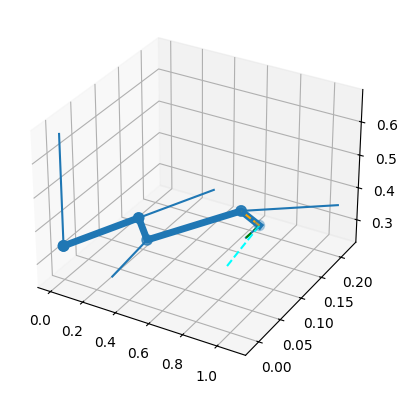

In [7]:
import matplotlib.pyplot
from mpl_toolkits.mplot3d import Axes3D
ax = matplotlib.pyplot.figure().add_subplot(111, projection='3d')

panda_chain.plot(angles, ax)
matplotlib.pyplot.show()

In [8]:
from ikpy.chain import Chain

franka_chain = Chain.from_urdf_file("franka.urdf")
print(franka_chain)

# Target position in Cartesian coordinates (x, y, z)
target_position = [0.5, 0.0, 0.5]

#joint_angles = franka_chain.inverse_kinematics(target_position)

#print("Joint angles for target position:", joint_angles)

ValueError: Error: link base_link given but not found in the URDF

In [ ]:
# objekte in simulation/ andere objekte in pfadplanung
# mehr Pfadpunkte kalkulieren
# TCP nach unten gerichtet
# Kolision von Roboter vermeiden
# pick and place komplett modellieren
# statt txt export mit Api arbeiten
